In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

In [3]:
mnist.data.shape

(70000, 784)

In [105]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X = X[:10000]
y = y[:10000]
X.shape

(10000, 784)

In [128]:
type(X)

numpy.ndarray

In [5]:
X /= 255.0

In [6]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

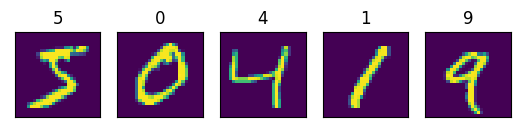

In [7]:
plot_example(X, y)

In [8]:
%%timeit -n 1 -r 1

# These are separate try/except blocks so that if the QR decomposition succeeds
# but the SVD fails, we don't have to recompute the QR decomposition.
# try:
#     Q = np.load('Q.npy')
#     R = np.load('R.npy')
# except OSError:
Q, R = linalg.qr(X)
np.save('Q.npy', Q)
np.save('R.npy', R)

# try:
#     U = np.load('U.npy')
#     s = np.load('s.npy')
#     Vh = np.load('Vh.npy')
# except OSError:
U, s, Vh = linalg.svd(R)
np.save('U.npy', U)
np.save('s.npy', s)
np.save('Vh.npy', Vh)

11.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
# Only have to run this once, the svd is very slow for such a big matrix
# Save the results and set load=True to load them
load = True

if load:
    U = np.load('U.npy')
    s = np.load('s.npy')
    Vh = np.load('Vh.npy')
else:
    U, s, Vh = linalg.svd(X)

In [10]:
U.shape, s.shape, Vh.shape

((10000, 10000), (784,), (784, 784))

In [11]:
np.save('U.npy', U)
np.save('s.npy', s)
np.save('Vh.npy', Vh)

Text(0, 0.5, 'Importance of Singular Values')

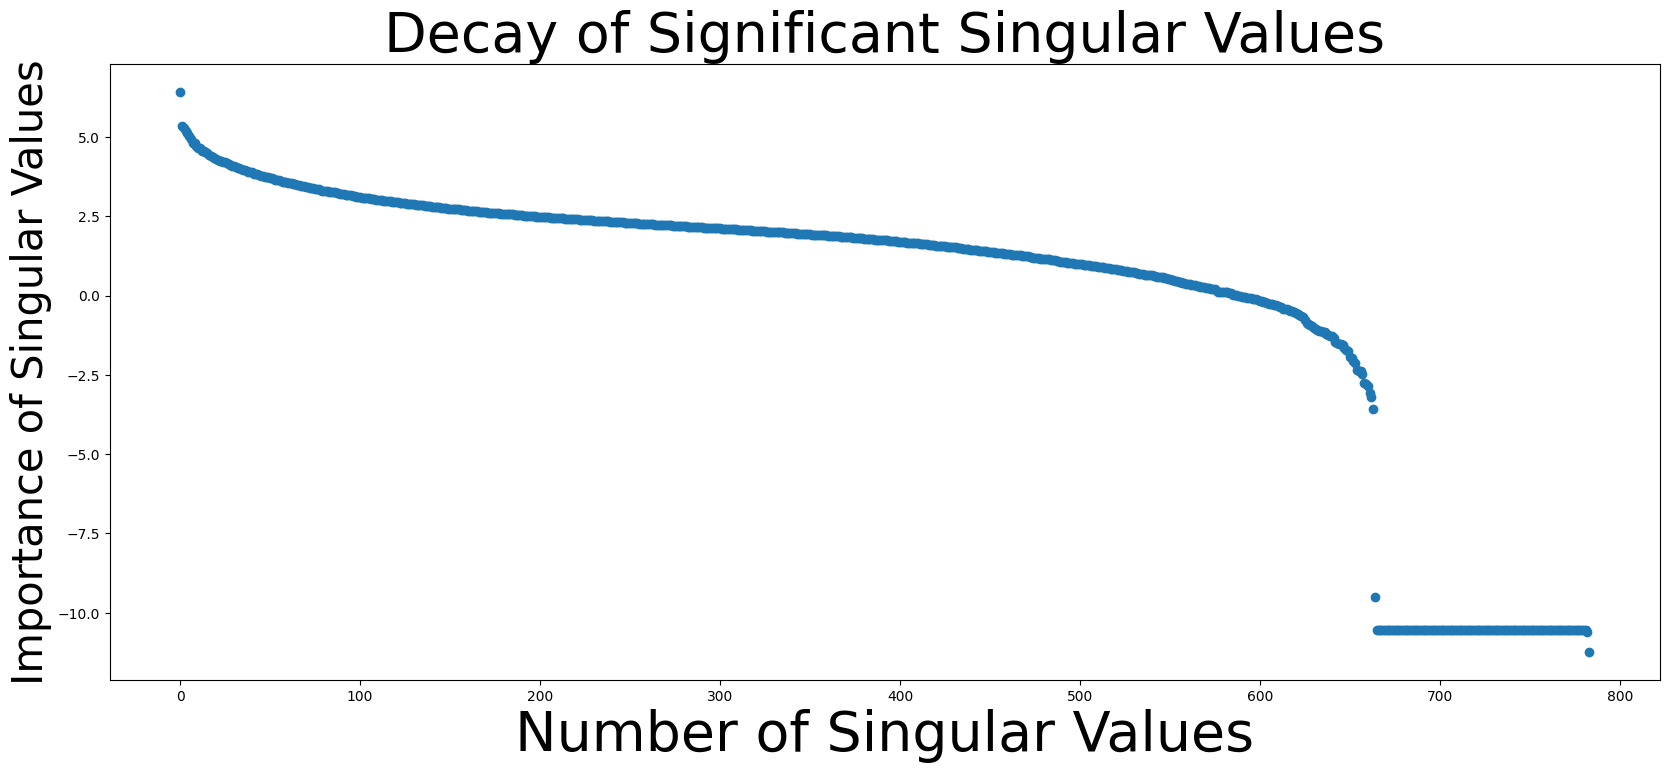

In [169]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s))
plt.title('Decay of Significant Singular Values', fontsize = 40)
plt.xlabel('Number of Singular Values', fontsize = 40)
plt.ylabel('Importance of Singular Values', fontsize = 30)

## Translation
- Find center of the bounding box
- Translate the bounding box center to the image center
- Add translation vector to dimensions
- SVD 

In [13]:
# modified code, original source: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def find_bbox(img):
    img = np.where(img>0.3, img, 0)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1

In [1]:
from tqdm import tqdm

X_recentered = np.zeros_like(X)

for i, img in tqdm(enumerate(X)):
    img = img.reshape(28,28)
    rmin, rmax, cmin, cmax = find_bbox(img)
    bbox_center = ((rmin + rmax)//2,  (cmin + cmax)//2)
    
    bbox_img = img[rmin:rmax, cmin:cmax]

    padr1 = padr2 = (28-(rmax-rmin))//2
    padc1 = padc2 = (28-(cmax-cmin))//2

    if (rmax+rmin)%2 == 1:
        padr2 += 1
    if (cmax+cmin)%2 == 1:
        padc2 += 1

    recentered_img = np.pad(bbox_img, ((padr1, padr2), (padc1, padc2)))
    X_recentered[i] = recentered_img.flatten()

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(recentered_img)

print(rmin, rmax, cmin, cmax)
print(bbox_center)
print('recentered shape', recentered_img.shape)

ModuleNotFoundError: No module named 'tqdm'

In [15]:
Q_rec, R_rec = linalg.qr(X_recentered)
U_rec, s_rec, Vh_rec = linalg.svd(R_rec)

s_rec.shape

NameError: name 'X_recentered' is not defined

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s_rec))
plt.title('Singular Values After Recentering')

## Split by class

In [ ]:
digits = {}
si_list = []

for i in range(10):
    digits[i] = X[y==i]

In [ ]:
for i in range(10):
    print(digits[i].shape)
    Qi, Ri = linalg.qr(digits[i])
    Ui, si, Vhi = linalg.svd(Ri)
    si_list.append(si)

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(10,30))

for i in range(10):
    ax[i].scatter(np.arange(0,784), np.log(si_list[i]))
    ax[i].set_title(f'Singular Values for Class [i]')

## Nonlinear transformation

In [2]:
X2 = (X>0.5).astype(np.float32)
plt.imshow(X2[100].reshape(28,28))

NameError: name 'X' is not defined

In [ ]:
Q2, R2 = linalg.qr(X2)
U2, s2, Vh2 = linalg.svd(R2)

In [ ]:
s2.shape

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s2))
plt.title('Singular Values After X -> {1, X>0.5; 0 otherwise}')

## k-means grouping

In [38]:
def twodim(vec, dim):
    result = []
    i = 1
    while i * dim <= len(vec):
        result = result + [vec[(i - 1)*dim:i*dim]]
        i = i + 1
    return result
x = [1, 2, 3, 4]
twodim(x, 2)

[[1, 2], [3, 4]]

In [ ]:
def center_of_mass(x):
    result = []
    for elem in x:
        xy = (0, 0)
        for val in elem:
            

In [35]:
x = [1, 2, 3, 4]
x[0:2]

[1, 2]

In [94]:
from scipy import ndimage
import numpy
print(ndimage.center_of_mass(np.array(twodim(X[1], 28)))[0])
print(X.shape)
ComX = []
for elem in X:
    ComX = ComX + [[ndimage.center_of_mass(np.array(twodim(elem, 28)))[0], ndimage.center_of_mass(np.array(twodim(elem, 28)))[1]]]
ComX = np.array(ComX)

13.553304389773276
(10000, 784)


In [95]:
def initialize_random_centroids(K, X):
    """Initializes and returns k random centroids"""
    m, n = np.shape(X)
    # a centroid should be of shape (1, n), so the centroids array will be of shape (K, n)
    centroids = np.empty((K, n))
    for i in range(K):
        # pick a random data point from X as the centroid
        centroids[i] =  X[np.random.choice(range(m))] 
    return centroids

def closest_centroid(x, centroids, K):
    """Finds and returns the index of the closest centroid for a given vector x"""
    distances = np.empty(K)
    for i in range(K):
        distances[i] = euclidean_distance(centroids[i], x)
    return np.argmin(distances) # return the index of the lowest distance

def create_clusters(centroids, K, X):
    """Returns an array of cluster indices for all the data samples"""
    m, _ = np.shape(X)
    cluster_idx = np.empty(m)
    for i in range(m):
        cluster_idx[i] = closest_centroid(X[i], centroids, K)
    return cluster_idx

def compute_means(cluster_idx, K, X):
    """Computes and returns the new centroids of the clusters"""
    _, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        points = X[cluster_idx == i] # gather points for the cluster i
        centroids[i] = np.mean(points, axis=0) # use axis=0 to compute means across points
    return centroids

def run_Kmeans(K, X, max_iterations=500):
    """Runs the K-means algorithm and computes the final clusters"""
    # initialize random centroids
    centroids = initialize_random_centroids(K, X)
    # loop till max_iterations or convergance
    print(f"initial centroids: {centroids}")
    for _ in range(max_iterations):
        # create clusters by assigning the samples to the closet centroids
        clusters = create_clusters(centroids, K, X)
        previous_centroids = centroids                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
        # compute means of the clusters and assign to centroids
        centroids = compute_means(clusters, K, X)
        # if the new_centroids are the same as the old centroids, return clusters
        diff = previous_centroids - centroids
        if not diff.any():
            return clusters
    return clusters

def euclidean_distance(x1, x2):
    """Calculates and returns the euclidean distance between two vectors x1 and x2"""
    return np.sqrt(np.sum(np.power(x1 - x2, 2)))


#its all from https://dev.to/sajal2692/coding-k-means-clustering-using-python-and-numpy-fg1 this guy

In [117]:
testData = [[1, 2], [3, 4], [5, 6]]
#print(ComX)
Xkmeans = run_Kmeans(10, ComX)


initial centroids: [[13.58247053 13.61340273]
 [13.9734699  13.75865938]
 [13.99314119 13.79985407]
 [14.11783666 13.69498894]
 [14.19505869 13.55032754]
 [14.14405567 14.17891519]
 [13.74545371 13.96215644]
 [14.1988453  14.21944869]
 [13.83911048 14.33314508]
 [13.76768366 13.70262039]]


array([1., 6., 1., 3., 1., 2., 5., 5., 3., 8.])

In [120]:
Xkmeans[:20]
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


initial centroids: [[ 8.97320324  9.36434006]
 [ 7.92520229 -0.551253  ]
 [ 6.80596377 -0.25678573]]


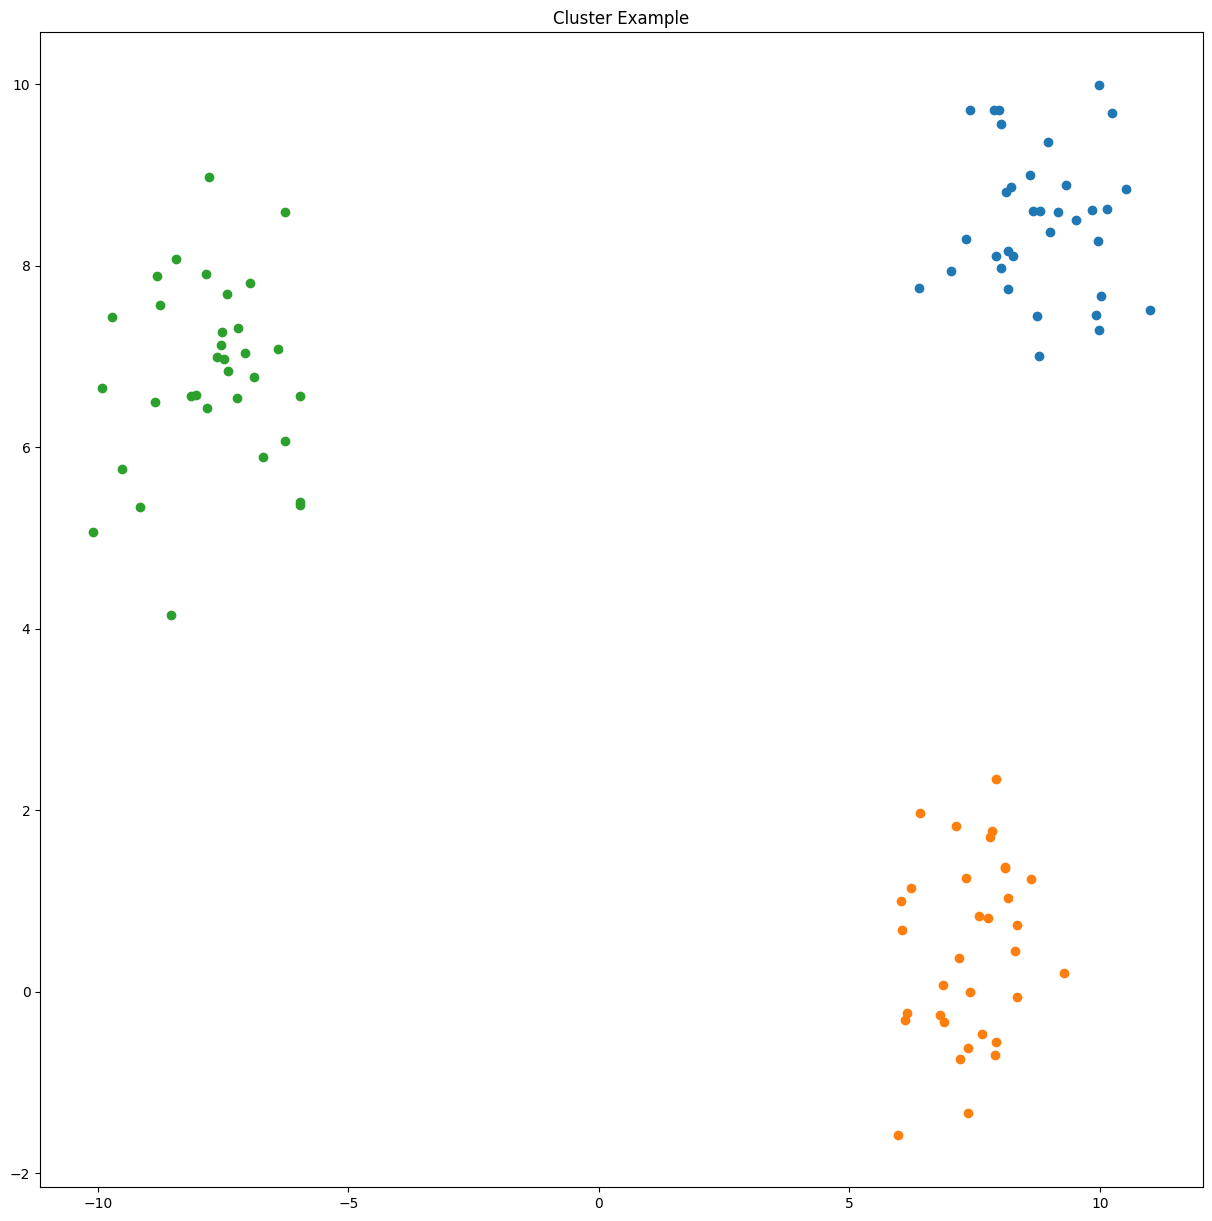

In [162]:
from sklearn import datasets
# creating a dataset for clustering
datX, y = datasets.make_blobs()
y_preds = run_Kmeans(3, datX, 10000)

plt.figure(figsize=(15,15))
plt.title('Cluster Example')
for i in range(3):
    xs = []
    ys = []
    for j in range(len(datX)):
        if y_preds[j] == i:
            
            xs = xs + [datX[j][0]]
            ys = ys + [datX[j][1]]
    plt.scatter(xs, ys)

Text(0.5, 1.0, 'Clusters of Image Vectors Based on Center of Mass')

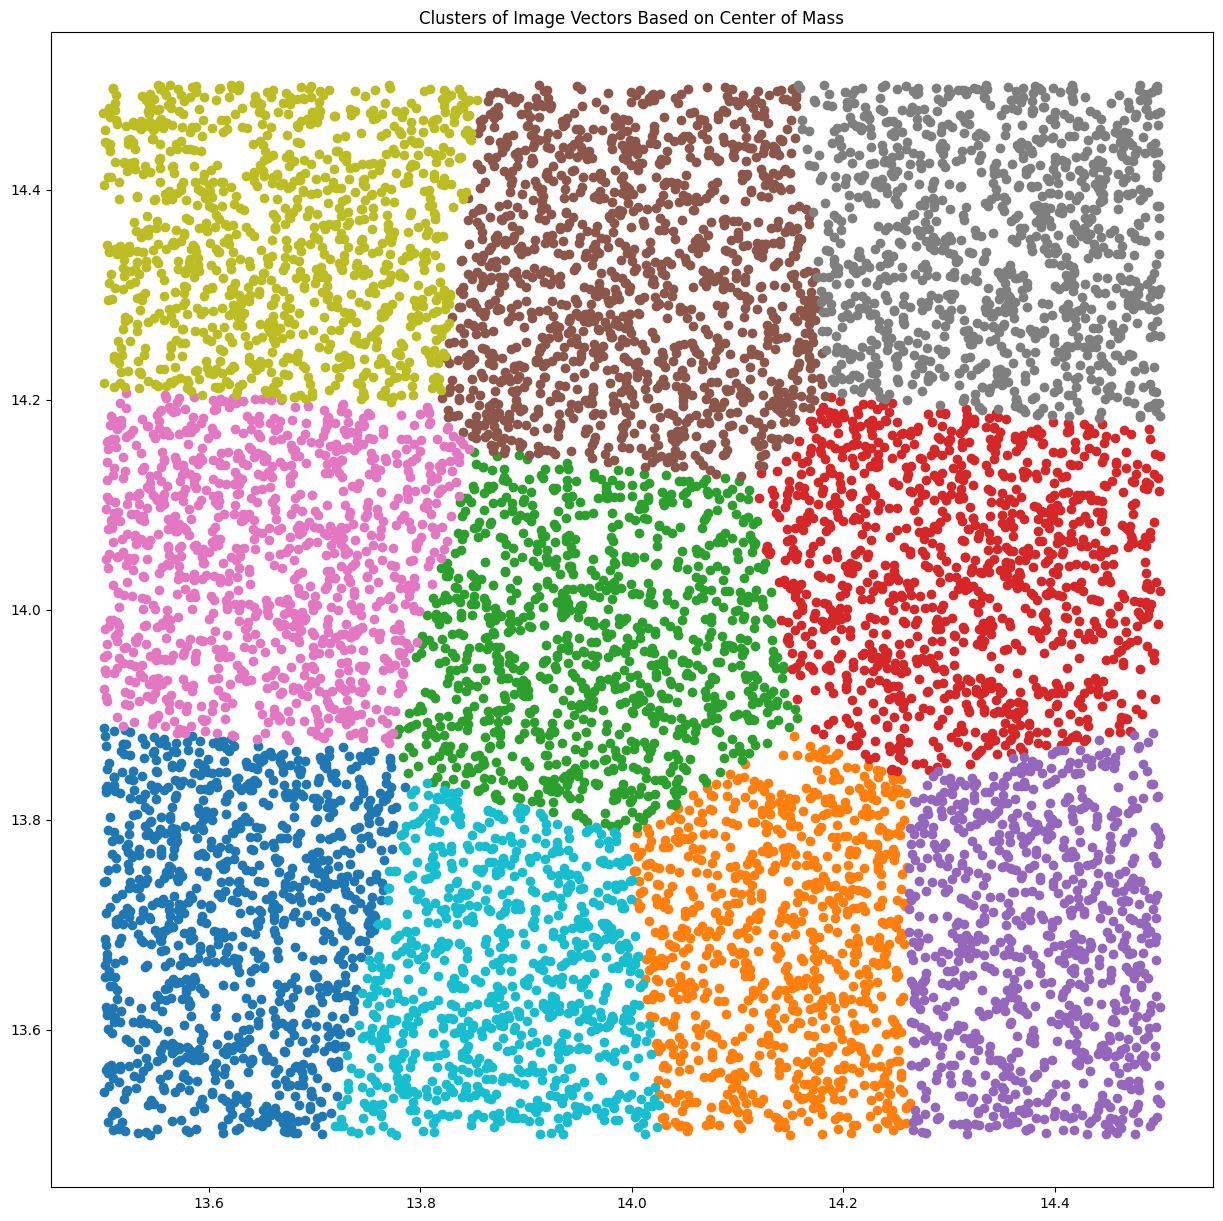

In [159]:
plt.figure(figsize=(15,15))


for i in range(10):
    xs = []
    ys = []
    for j in range(len(ComX)):
        if Xkmeans[j] == i:
            
            xs = xs + [ComX[j][0]]
            ys = ys + [ComX[j][1]]
    plt.scatter(xs, ys)

plt.title('Clusters of Image Vectors Based on Center of Mass')

In [147]:
X3 = []
for i in range(len(X)):
    X3 = X3 + [np.append(X[i], [Xkmeans[i]])]
X3 = np.array(X3)

numpy.ndarray

In [149]:
Q3, R3 = linalg.qr(X3)
U3, s3, Vh3 = linalg.svd(R3)

Text(0.5, 1.0, 'Singular Values After Adding Clustering as an Additional Dimension')

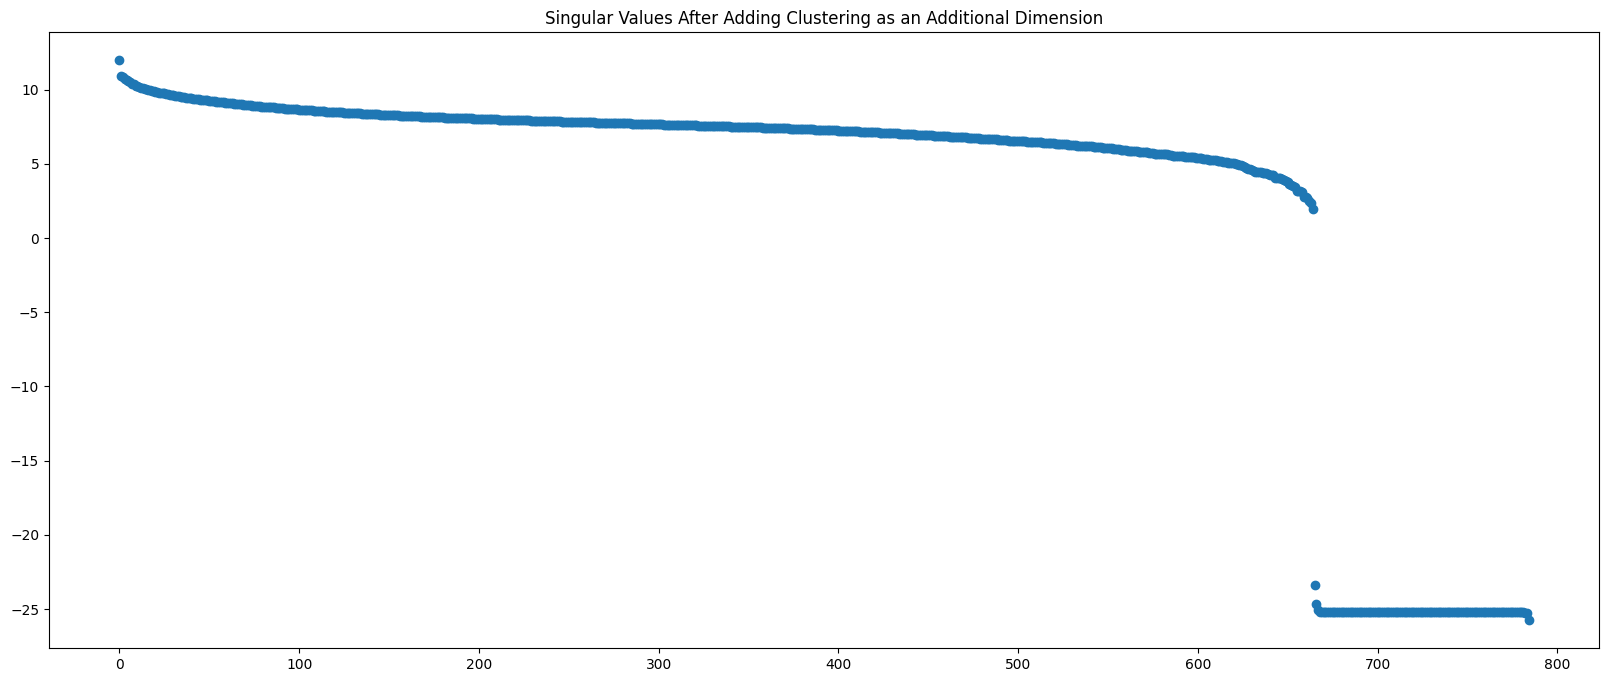

In [152]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,785), np.log(s3))
plt.title('Singular Values After Adding Clustering as an Additional Dimension')

In [ ]:
#So i didn't do kcluster with the features of the image as the dimensions, the runtime, even with max settings on idas, would be literally hours if not days. 